In [1]:
import pandas as pd

In [2]:
import torch
torch.cuda.is_available()

True

In [2]:
import scanpy as sc

In [4]:
sc.settings.verbosity = 3  
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

2024-06-09 00:04:19.332272: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 00:04:20.766225: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.13.0 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


In [3]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [4]:
import scvi

In [7]:
adata_4 = sc.read_10x_h5(
    "/home/mmigl/cellbender/output/sample4_filtered_filtered.h5"
)

In [8]:
adata_4

AnnData object with n_obs × n_vars = 1897 × 37143
    var: 'gene_ids', 'feature_types', 'genome'

In [161]:
#Pre-processing for improving the quality of the data before analysis

In [9]:
adata_4.var_names_make_unique()
sc.pp.filter_cells(adata_4, min_genes=200) 
sc.pp.filter_genes(adata_4, min_cells=3) 

In [10]:
adata_4

AnnData object with n_obs × n_vars = 1353 × 15286
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [190]:
#Doublet Removal

In [23]:
#pip install --user scikit-misc

In [11]:
doublet_4 = adata_4.copy()

In [12]:
sc.pp.highly_variable_genes(doublet_4, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')

In [13]:
scvi.model.SCVI.setup_anndata(doublet_4)
vae = scvi.model.SCVI(doublet_4)
vae.train()

CUDA backend failed to initialize: Unable to use CUDA because of the following issues with CUDA components:
Outdated cuDNN installation found.
Version JAX was built against: 8906
Minimum supported: 8900
Installed version: 8700
The local installation version must be no lower than 8900. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 400/400: 100%|████████████████████| 400/400 [00:36<00:00, 11.22it/s, v_num=1, train_loss_step=488, train_loss_epoch=514]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████| 400/400 [00:36<00:00, 11.07it/s, v_num=1, train_loss_step=488, train_loss_epoch=514]


In [14]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 343/400:  86%|█████████████▋  | 343/400 [00:30<00:05, 11.15it/s, v_num=1, train_loss_step=0.369, train_loss_epoch=0.418]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.471. Signaling Trainer to stop.


In [15]:
doublet = solo.predict()
doublet['prediction'] = solo.predict(soft = False)

In [16]:
doublet.groupby('prediction').count()

,doublet,singlet
prediction,,
doublet,526,526
singlet,827,827


In [17]:
doublet['difference'] = doublet.doublet - doublet.singlet

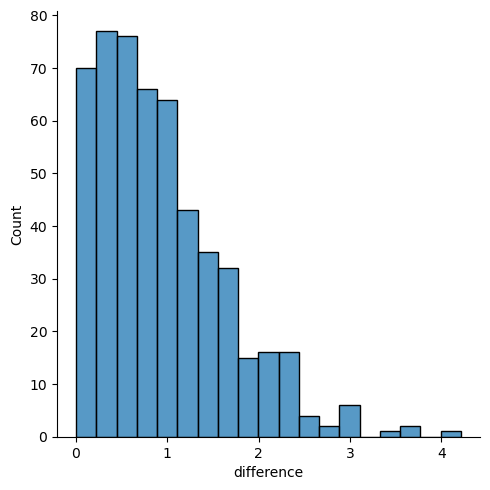

In [18]:
import seaborn as sns
sns.displot(doublet[doublet.prediction == 'doublet'], x = 'difference')

In [19]:
doublet = doublet[(doublet['prediction'] == 'doublet') & (doublet['difference'] > 1)]

In [20]:
adata_4.obs['doublet'] = adata_4.obs.index.isin(doublet.index)

In [21]:
adata_4 = adata_4[~adata_4.obs.doublet]

In [22]:
adata_4

View of AnnData object with n_obs × n_vars = 1152 × 15286
    obs: 'n_genes', 'doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [23]:
adata_4.var["mt"] = adata_4.var_names.str.startswith("MT-")

In [24]:
sc.pp.calculate_qc_metrics(adata_4, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

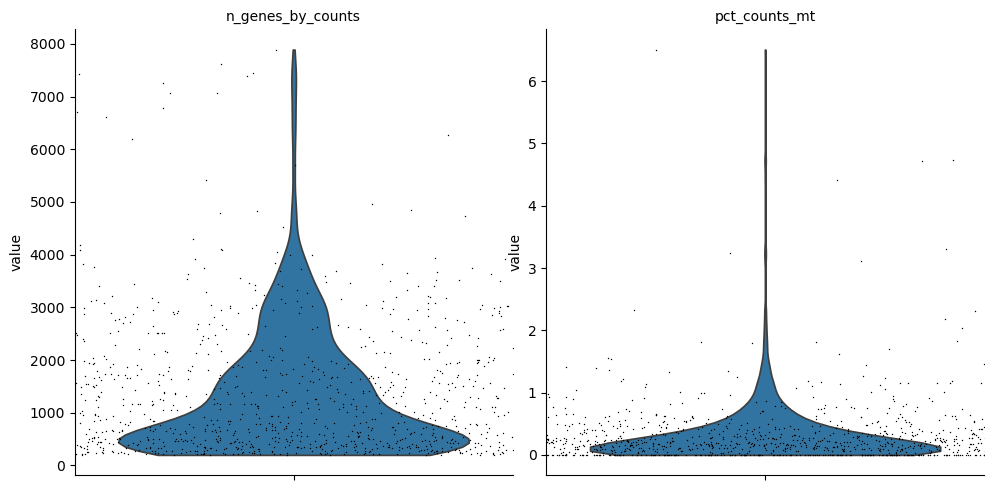

In [25]:
sc.pl.violin(adata_4, ['n_genes_by_counts', 'pct_counts_mt'], 
             jitter=0.6, multi_panel=True)

In [26]:
import numpy as np

In [27]:
def pp(adata):
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[(adata.obs.n_genes_by_counts < upper_lim)]
    adata = adata[adata.obs.pct_counts_mt < 1]
    sc.write('adata_4_filtered_new.h5ad', adata)
    adata.layers['Counts'] = adata.X.copy()
    sc.pp.normalize_total(adata) 
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset = True, layer = 'Counts', flavor = "seurat_v3")
    adata.raw = adata 
    adata = adata[:, adata.var.highly_variable] 
    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) 
    sc.pp.scale(adata, max_value=10) 
    sc.tl.pca(adata, svd_solver='arpack')
    sc.write('adata_4_pca_new.h5ad', adata)
    return adata

In [28]:
adata_4 = pp(adata_4)

In [29]:
adata_4

AnnData object with n_obs × n_vars = 1068 × 2000
    obs: 'n_genes', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'Counts'

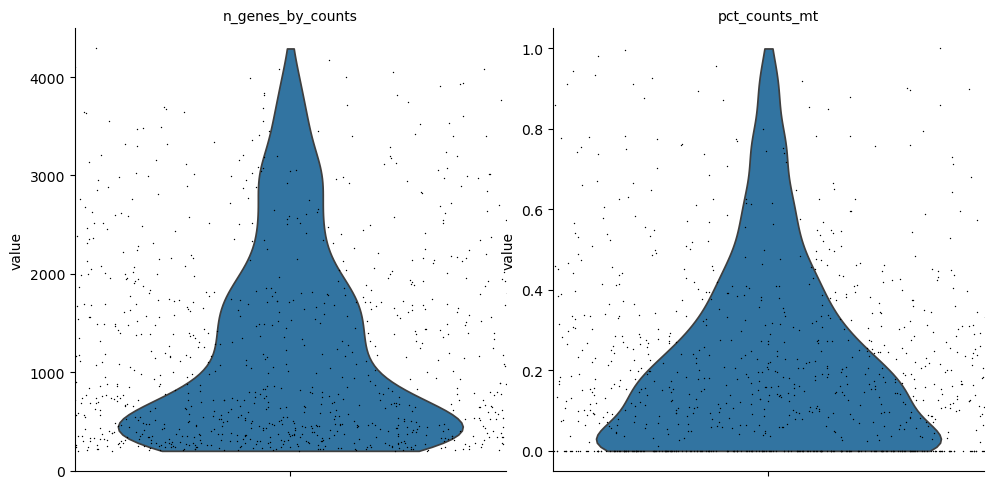

In [30]:
sc.pl.violin(adata_4, ['n_genes_by_counts', 'pct_counts_mt'], 
             jitter=0.6, multi_panel=True)

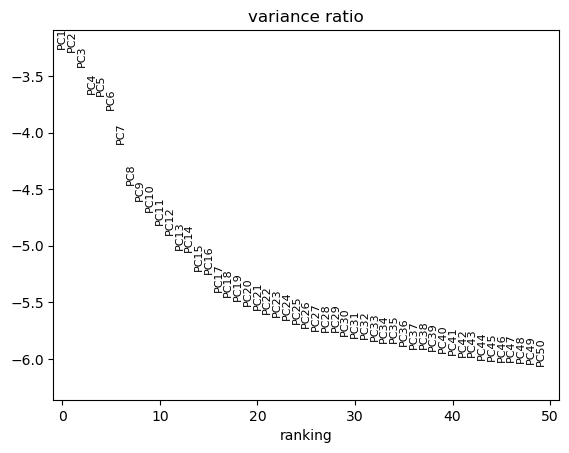

In [31]:
sc.pl.pca_variance_ratio(adata_4, log=True, n_pcs=50)

In [32]:
sc.pp.neighbors(adata_4, n_pcs=43)
sc.tl.umap(adata_4)
sc.tl.leiden(adata_4, resolution = 0.5)
sc.tl.rank_genes_groups(adata_4, "leiden", method="wilcoxon")
sc.write('adata_4_de_new.h5ad', adata_4)

2024-06-09 10:15:28.634211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


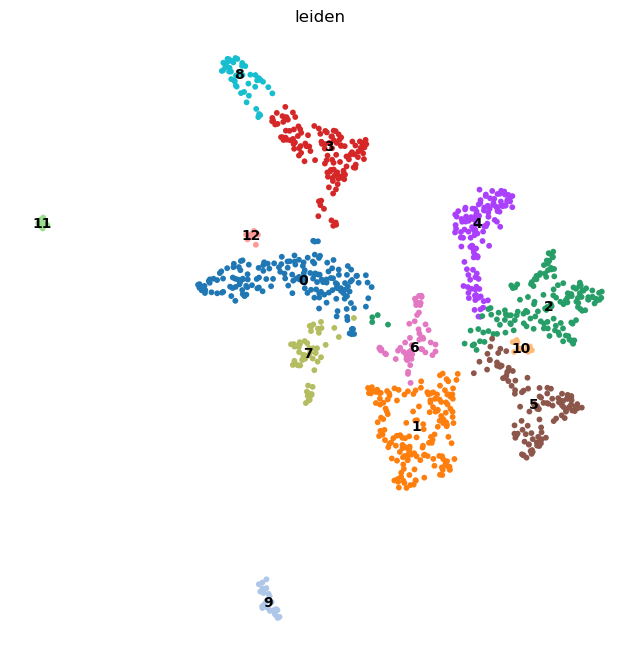

In [33]:
from matplotlib import rc_context
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata_4, color = 'leiden', s = 70, frameon=False, legend_loc="on data", alpha=1)

In [44]:
n_markers = ['S100A12', 'CXCL8', 'IL1B', 'MMP9']

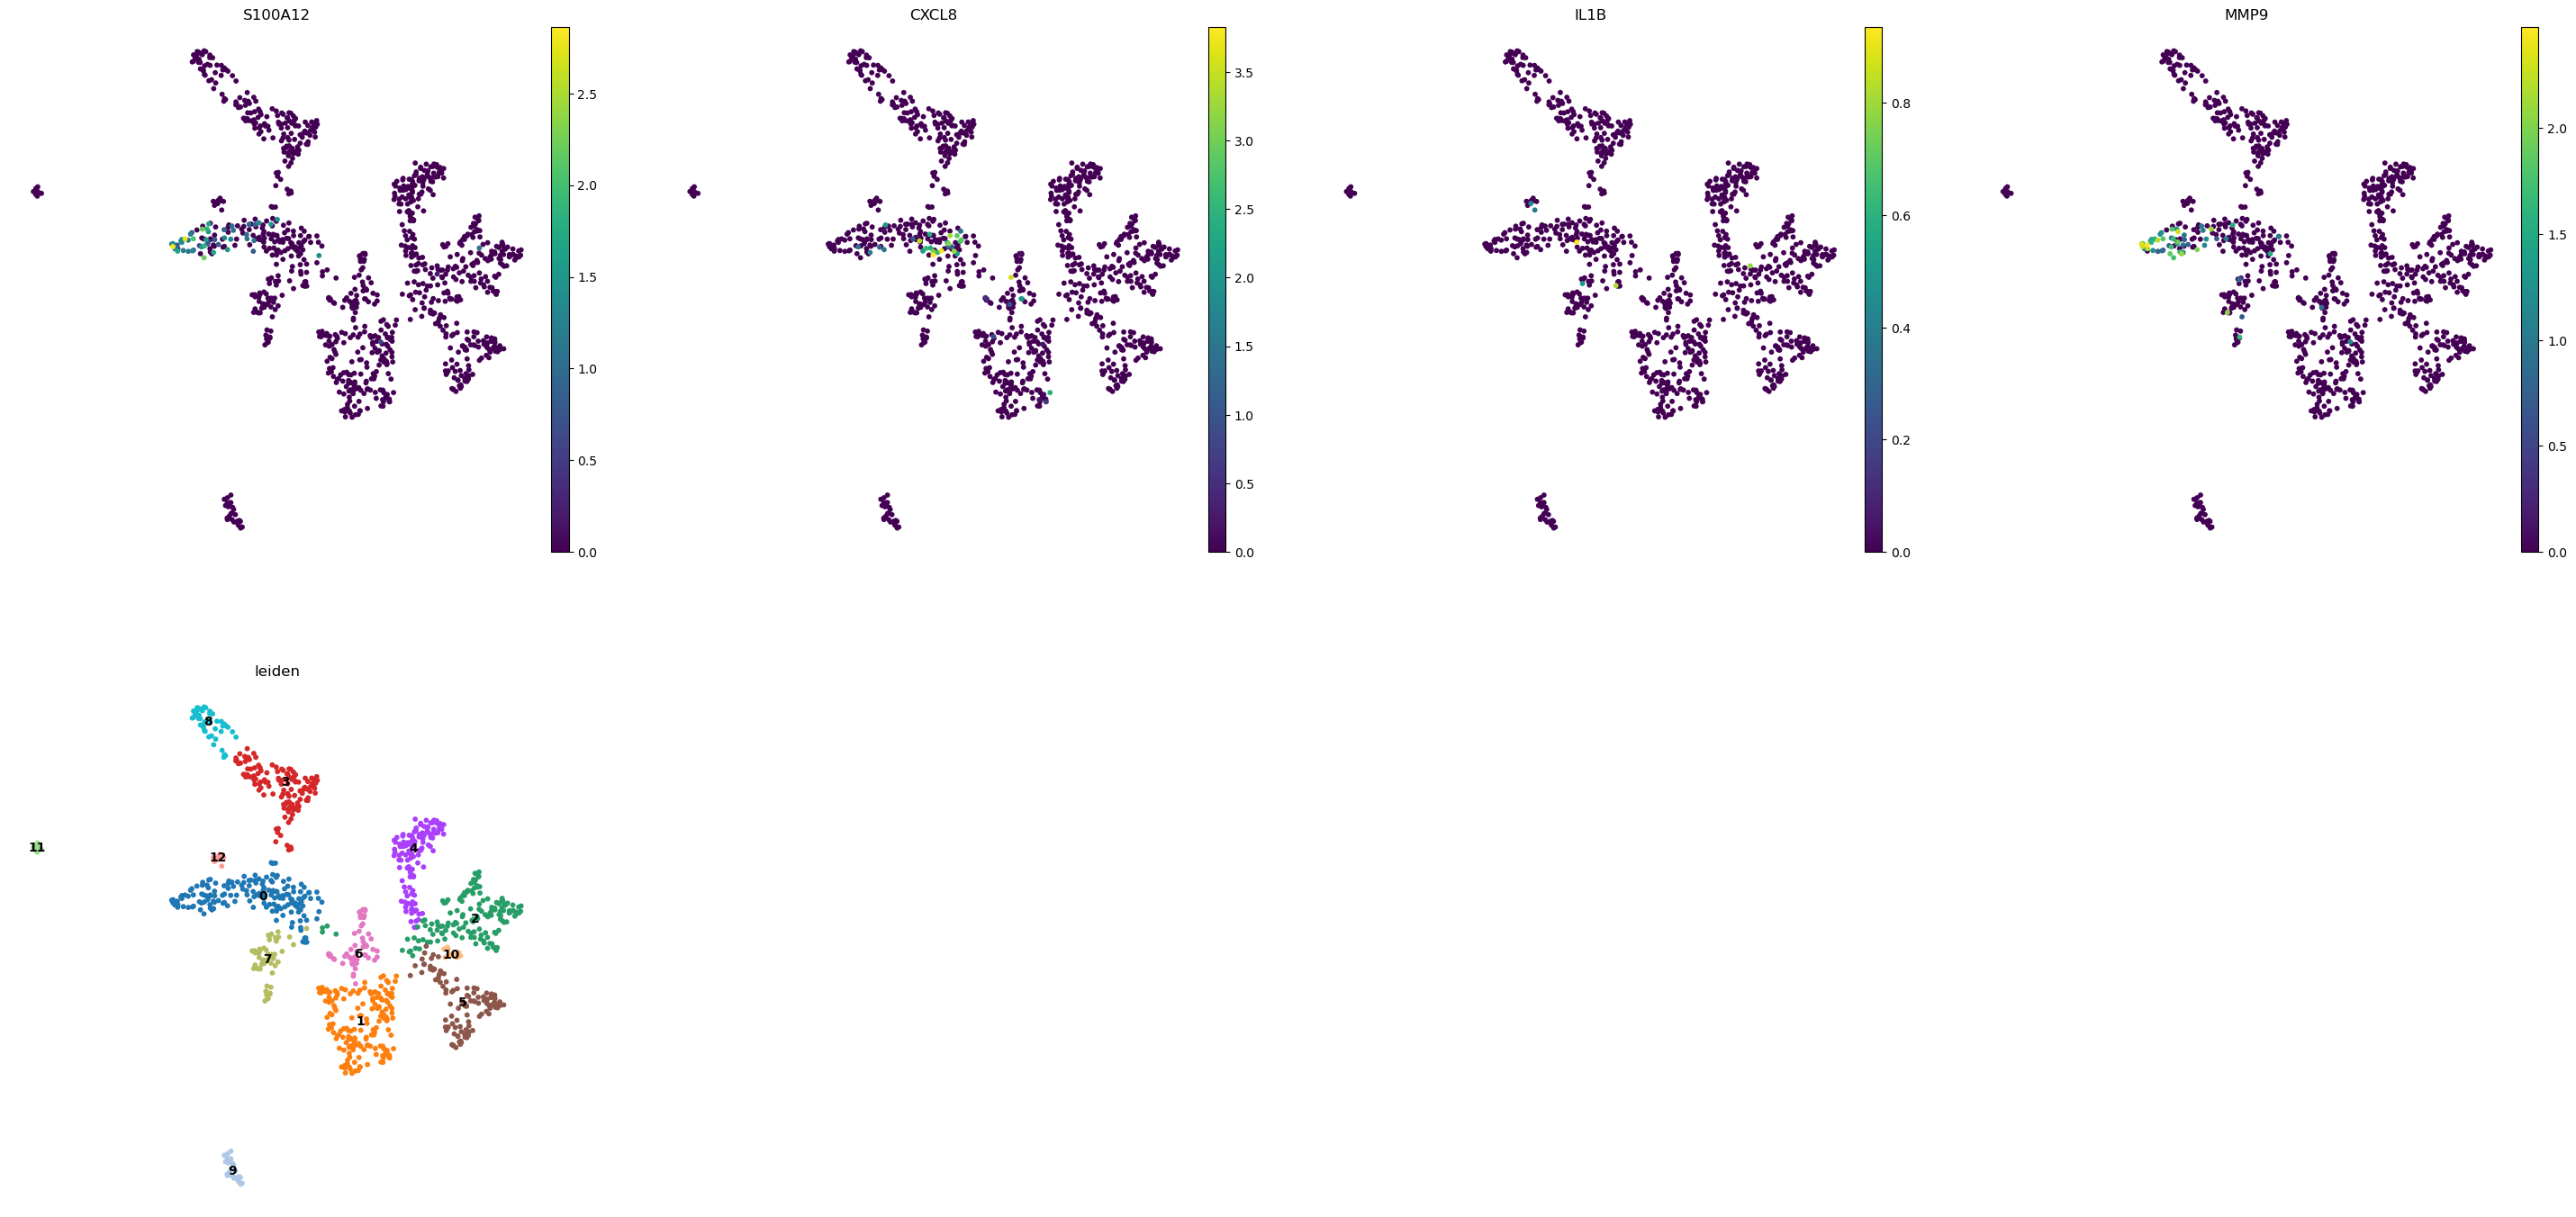

In [45]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata_4, color=n_markers + ['leiden'], s = 70, frameon=False, legend_loc="on data", alpha=1)

In [46]:
markers = {}
for c in adata_4.obs['leiden'].cat.categories:
    df = sc.get.rank_genes_groups_df(adata_4, group=c)
    markers[c] = df['names'].tolist()[:5]

In [47]:
markers

{'0': ['SLC11A1', 'S100A9', 'S100A8', 'SPI1', 'ITGAX'],
 '1': ['NAPSA', 'SLPI', 'ABCA3', 'PGC', 'NPC2'],
 '2': ['CLDN5', 'EGFL7', 'CAVIN2', 'TMEM100', 'CDH5'],
 '3': ['ITK', 'CD96', 'IL7R', 'TRAC', 'ITGA4'],
 '4': ['TACSTD2', 'SCEL', 'CGN', 'WFS1', 'EPS8L2'],
 '5': ['DCN', 'LTBP4', 'FN1', 'FBLN1', 'DEPRECATED_ENSG00000175899'],
 '6': ['WFDC2', 'PIGR', 'CAPS', 'TSPAN1', 'TACSTD2'],
 '7': ['C1QA', 'CTSB', 'CD163', 'C1QB', 'C1QC'],
 '8': ['NKG7', 'GNLY', 'PRF1', 'KLRD1', 'ADGRG1'],
 '9': ['MYH11', 'ACTA2', 'COL6A2', 'TPM2', 'SPEG'],
 '10': ['COL4A1', 'NID1', 'OBSCN', 'CCN2', 'NOTCH3'],
 '11': ['HDC', 'KIT', 'TPSAB1', 'CPA3', 'TPSB2'],
 '12': ['SIGLEC10', 'FGD2', 'AIF1', 'MPEG1', 'ADA2']}

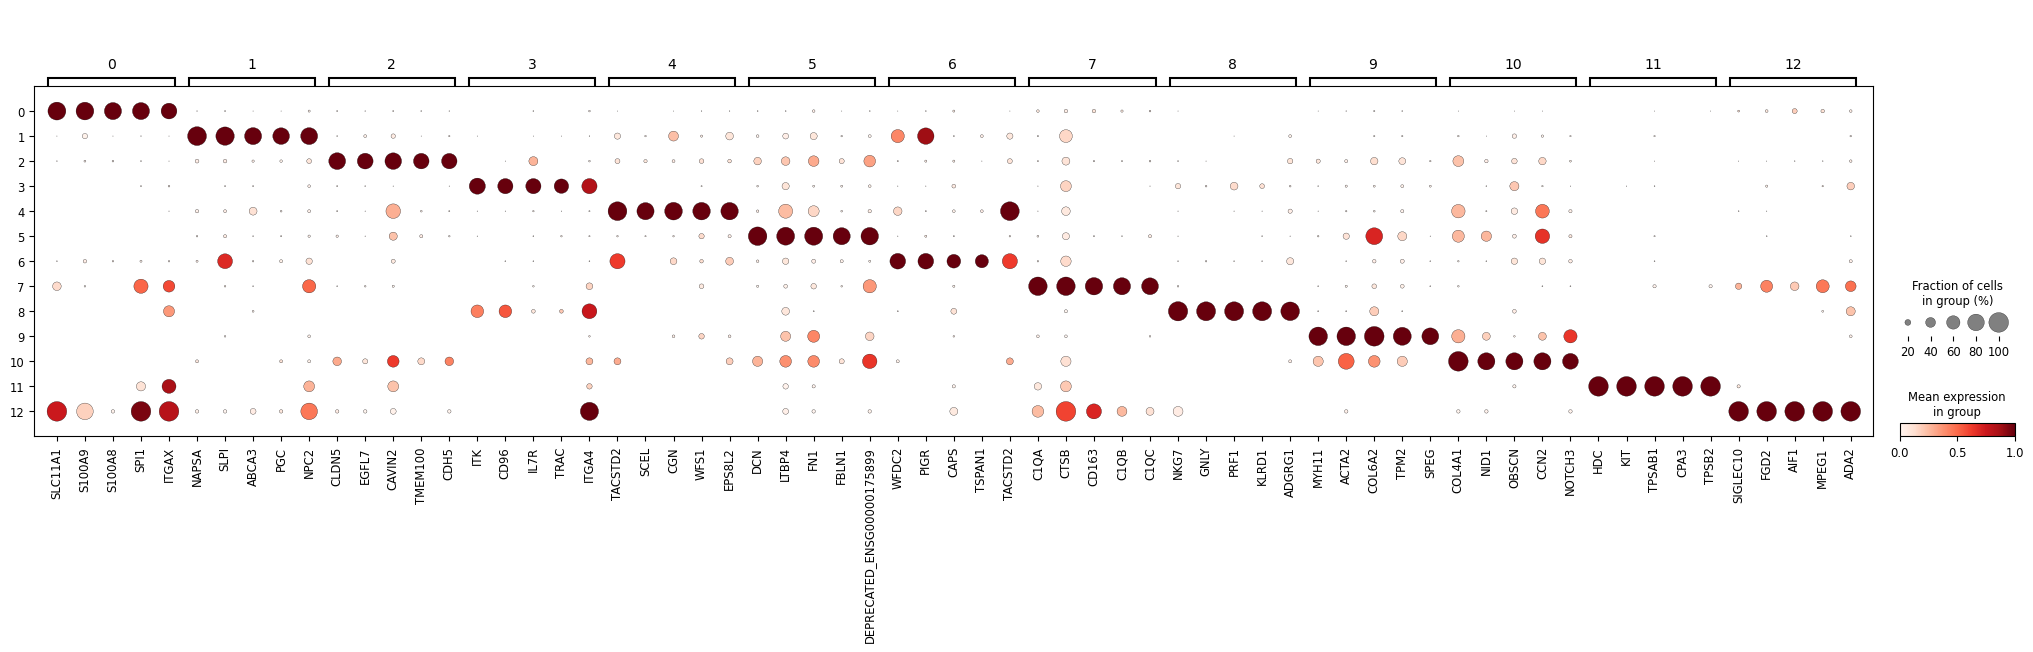

In [48]:
sc.pl.dotplot(adata_4, markers, groupby='leiden', use_raw=True, standard_scale='var')

In [42]:
#subset_adata_3 = adata_3[adata_3.obs['leiden'].isin(['13','4','7','0']), :]

In [44]:
#sc.pp.neighbors(subset_adata_3, n_pcs=41)
#sc.tl.leiden(subset_adata_3, resolution = 0.5)
#sc.tl.umap(subset_adata_3)
#sc.write('subset_adata_3.h5ad', subset_adata_3)

In [49]:
#with rc_context({'figure.figsize': (8, 8)}):
#    sc.pl.umap(subset_adata_3, color = 'leiden', s = 70, frameon=False, legend_loc="on data", alpha=1)

In [50]:
#with rc_context({'figure.figsize': (8, 8)}):
#    sc.pl.umap(subset_adata_3, color=n_markers + ['leiden'], s = 70, frameon=False, legend_loc="on data", alpha=1)

In [ ]:
#SCVI for clustering

In [51]:
import scvi
def model(adata):
    adata.layers['Counts'] = adata.X.copy()
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset = True, layer = 'Counts', flavor = "seurat_v3")
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable] 
    adata = adata.copy()
    scvi.model.SCVI.setup_anndata(adata, layer = "Counts", continuous_covariate_keys=['pct_counts_mt', 'total_counts'])
    vae = scvi.model.SCVI(adata)
    vae.train()
    vae.save(model_path)
    adata.obsm['X_scVI'] = vae.get_latent_representation()
    adata.layers["X_normalized_scVI"] = vae.get_normalized_expression()
    sc.pp.neighbors(adata, use_rep="X_scVI")
    sc.tl.umap(adata)
    return adata

In [52]:
scvi_adata_4 = sc.read('adata_4_filtered_new.h5ad')

In [53]:
model_path = 'vae_model_4/'

In [54]:
scvi_adata_4 = model(scvi_adata_4)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 400/400: 100%|████████████████████| 400/400 [00:31<00:00, 12.91it/s, v_num=1, train_loss_step=445, train_loss_epoch=461]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████| 400/400 [00:31<00:00, 12.88it/s, v_num=1, train_loss_step=445, train_loss_epoch=461]


In [56]:
vae = scvi.model.SCVI.load(model_path, adata=scvi_adata_4)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File vae_model_4/model.pt already downloaded                                                              


In [57]:
scvi_adata_4

AnnData object with n_obs × n_vars = 1068 × 2000
    obs: 'n_genes', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap'
    obsm: '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap'
    layers: 'Counts', 'X_normalized_scVI'
    obsp: 'distances', 'connectivities'

In [58]:
sc.tl.leiden(scvi_adata_4, resolution = 0.5)
sc.write('adata_4_scvi_new.h5ad', scvi_adata_4)

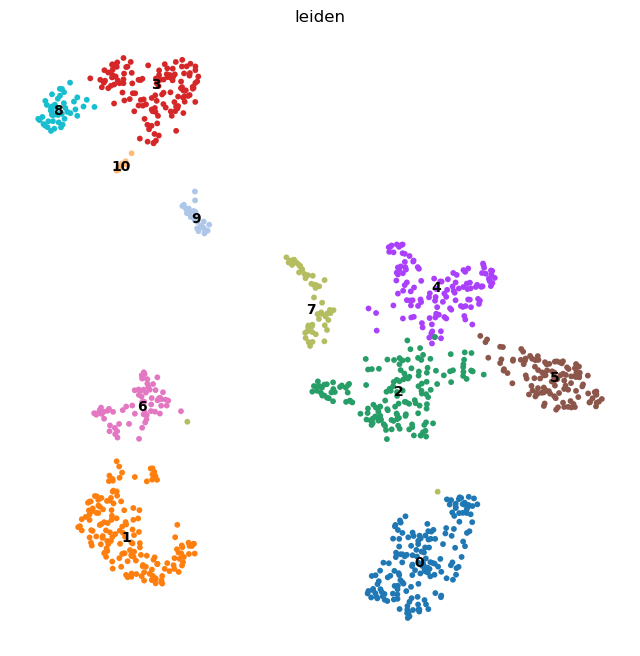

In [59]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(scvi_adata_4, color = 'leiden', s = 70, frameon=False, legend_loc="on data", alpha=1)

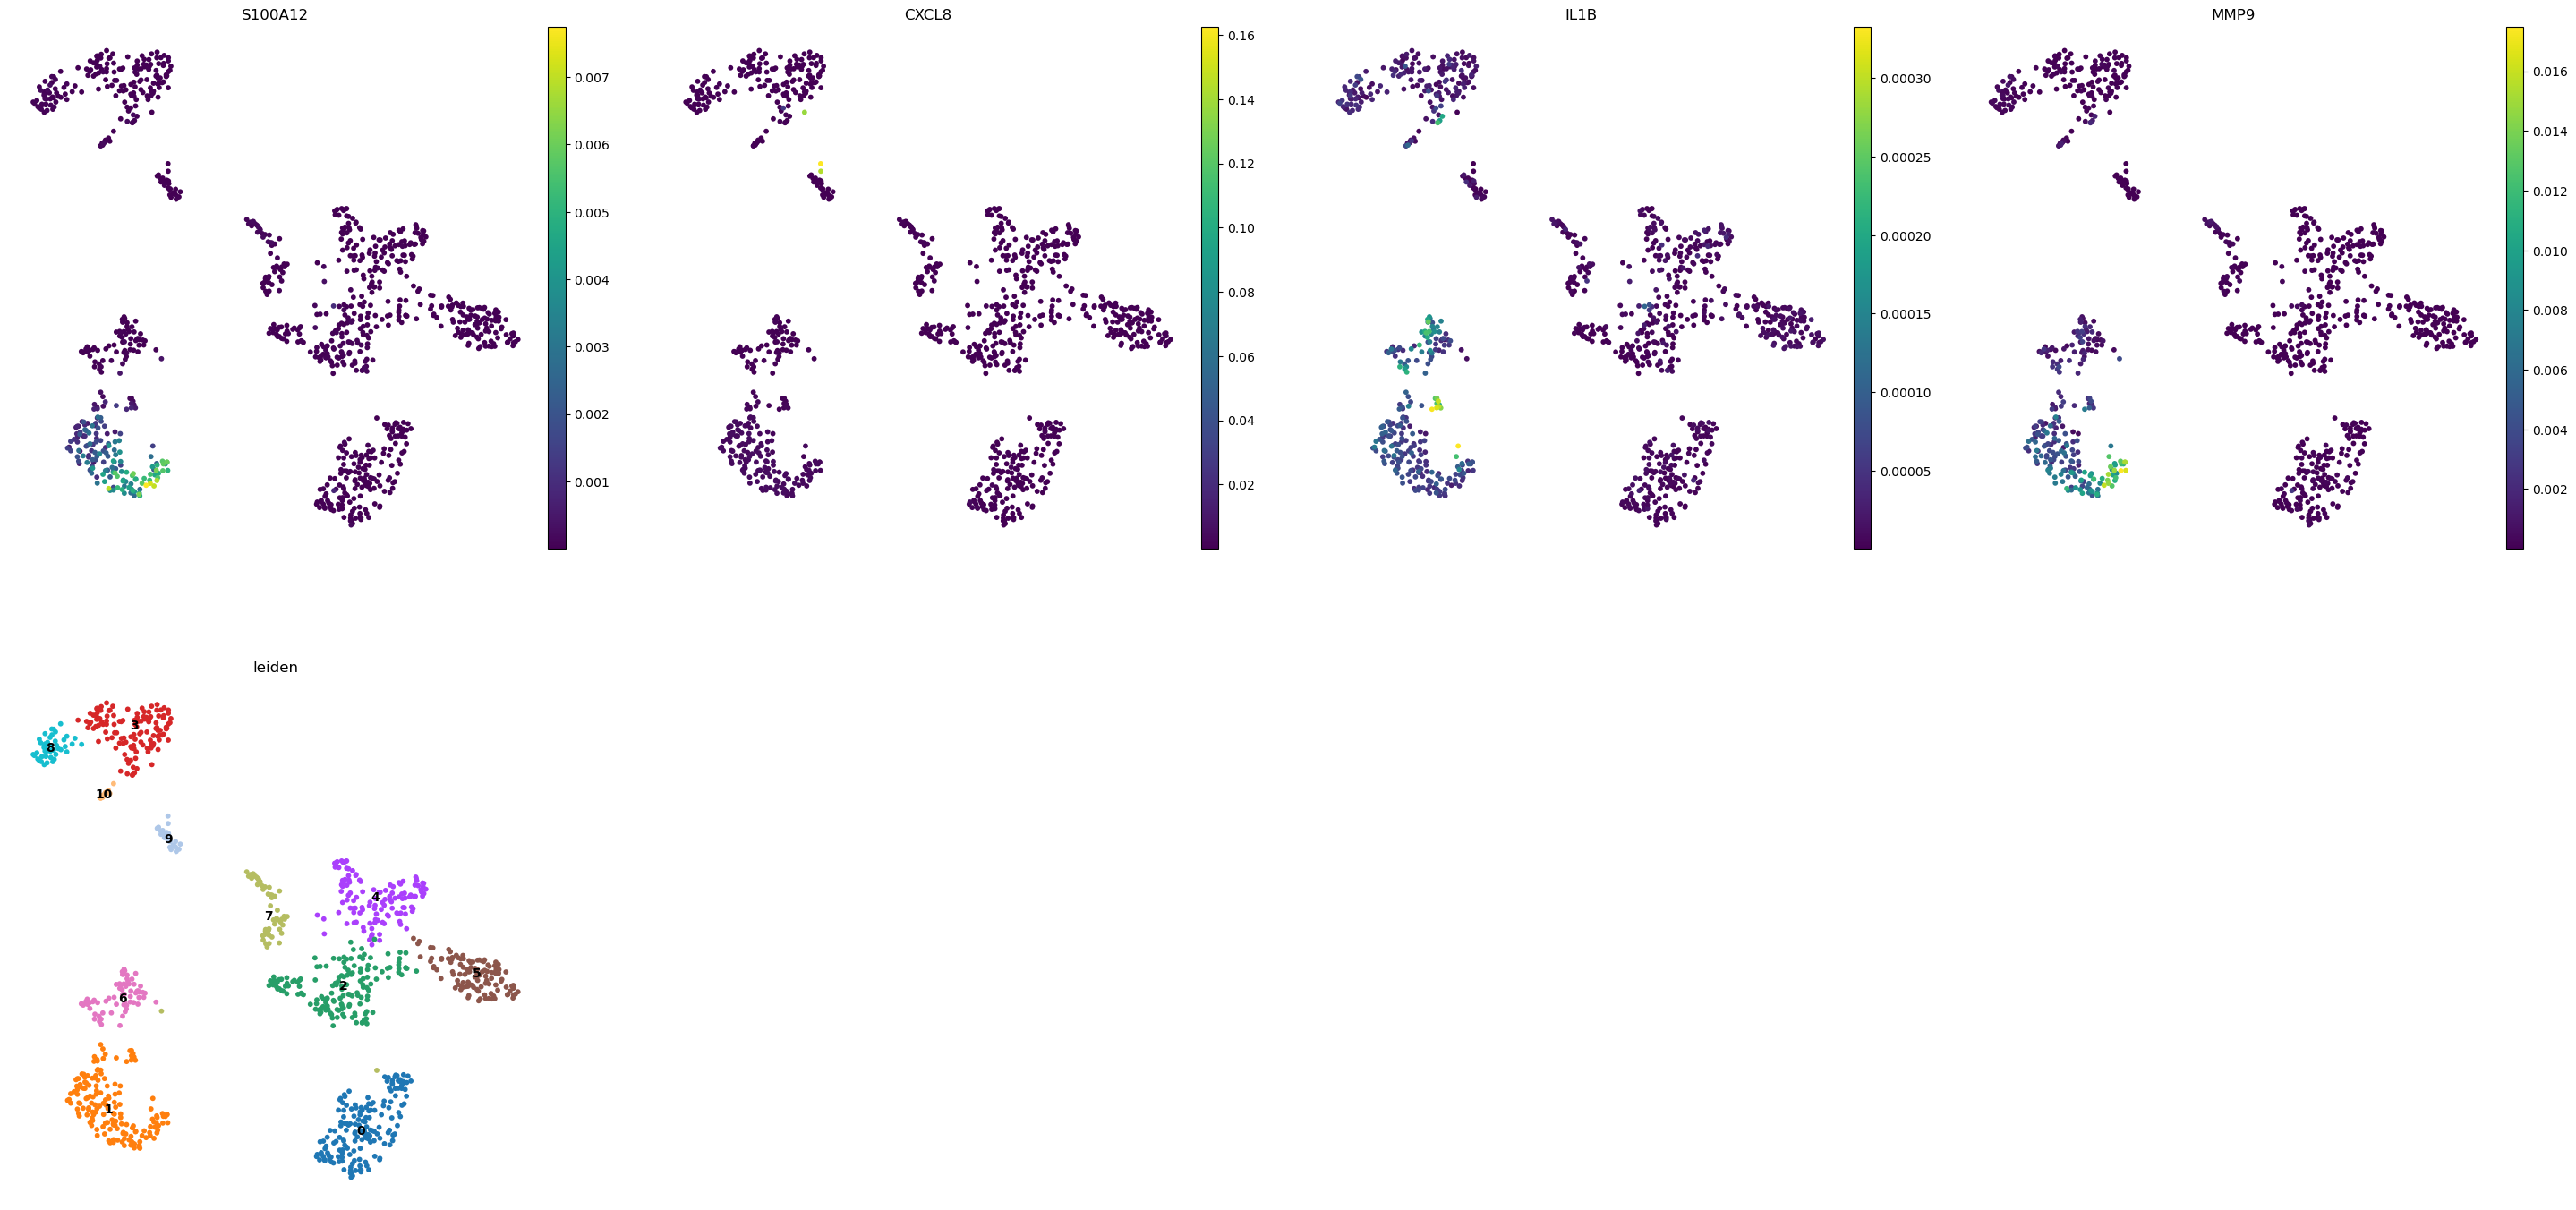

In [60]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(scvi_adata_4, color = n_markers + ['leiden'], s = 70, frameon=False, legend_loc="on data", alpha=1, layer = "X_normalized_scVI")

In [61]:
scvi_df_4 = vae.differential_expression(groupby = 'leiden')

DE...: 100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:11<00:00,  1.00s/it]


In [62]:
#scvi_df_4.to_csv('scvi_de_4_results.csv', index=False)

In [63]:
scvi_markers_4 = {}
for c in scvi_adata_4.obs.leiden.cat.categories:
    cell_df = scvi_df_4.loc[scvi_df_4.group1 == c]
    scvi_markers_4[c] = cell_df.index.tolist()[:5]

In [64]:
scvi_markers_4

{'0': ['ETV5', 'LAMP3', 'MID1IP1', 'PGC', 'PARM1'],
 '1': ['MME', 'SLC11A1', 'FCAR', 'NFE2', 'MNDA'],
 '2': ['DLL4', 'FZD4', 'SHANK3', 'ECSCR', 'PCDH17'],
 '3': ['PDCD1', 'IL2RB', 'THEMIS', 'CD5', 'CD247'],
 '4': ['CACNA1C', 'PDZRN3', 'RASL12', 'FBLN1', 'COL6A1'],
 '5': ['NTM', 'CEACAM5', 'ROR1', 'GPRIN2', 'TUFT1'],
 '6': ['SLAMF8', 'MS4A4A', 'C1QC', 'VSIG4', 'APOE'],
 '7': ['C1orf194', 'MUC4', 'SLC44A4', 'PTPRT', 'GSTA1'],
 '8': ['S1PR5', 'TRDC', 'FGFBP2', 'KLRF1', 'NCR1'],
 '9': ['JPH2', 'ACTN2', 'FOXC2', 'ITGA7', 'CASQ2'],
 '10': ['CPA3', 'TPSB2', 'SIGLEC6', 'PIK3R6', 'CDK15']}

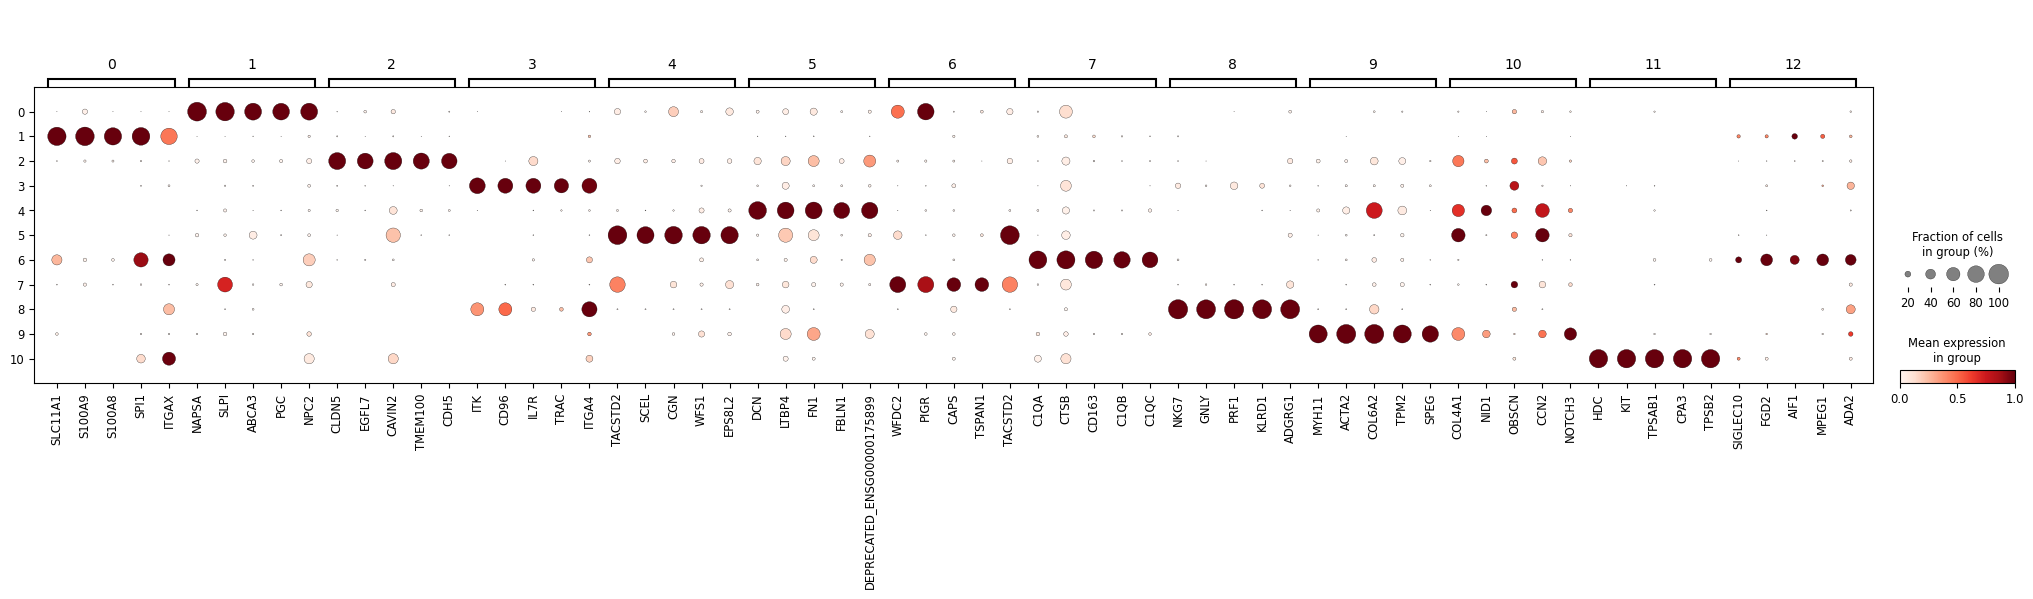

In [65]:
sc.pl.dotplot(scvi_adata_4, markers, groupby='leiden', use_raw=True, standard_scale='var')

In [61]:
#subset_scvi_adata_3 = scvi_adata_3[adata_3.obs['leiden'].isin(['12','4','0','7']), :]

In [66]:
#subset_scvi_adata_3

In [67]:
#sc.pp.neighbors(subset_scvi_adata_3, use_rep="X_scVI")
#sc.tl.umap(subset_scvi_adata_3)

In [70]:
#sc.tl.leiden(subset_scvi_adata_3, resolution = 0.5)

In [64]:
#sc.write('subset_scvi_adata_3.h5ad', subset_scvi_adata_3)

In [67]:
#with rc_context({'figure.figsize': (8, 8)}):
#    sc.pl.umap(subset_scvi_adata_3, color = 'leiden', s = 70, frameon=False, legend_loc="on data", alpha=1)

In [68]:
#with rc_context({'figure.figsize': (8, 8)}):
#    sc.pl.umap(subset_scvi_adata_3, color=n_markers + ['leiden'], s = 70, frameon=False, legend_loc="on data", alpha=0.8, layer = "X_normalized_scVI")